In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

20:30:28 - cmdstanpy - INFO - Chain [1] start processing
20:30:28 - cmdstanpy - INFO - Chain [1] done processing


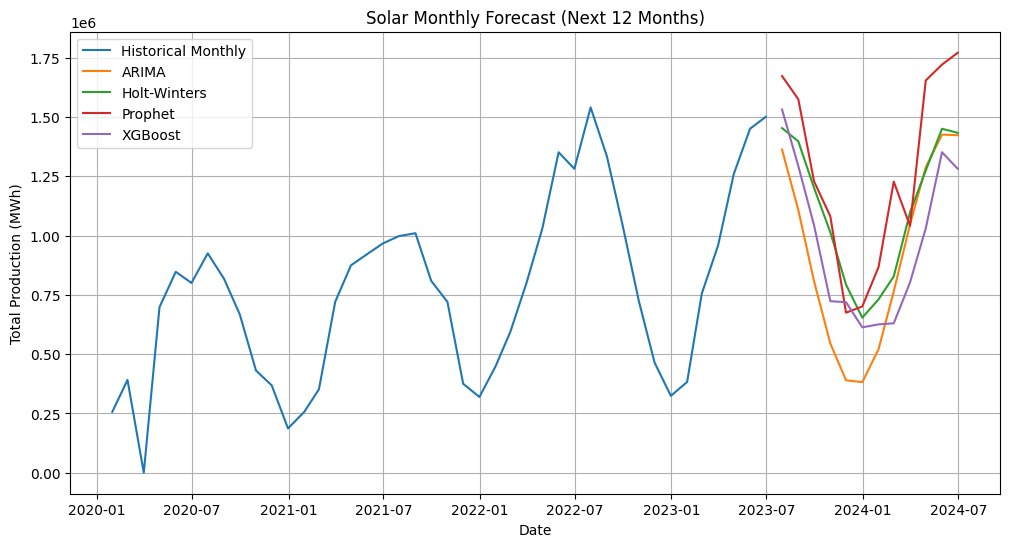

20:30:29 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing


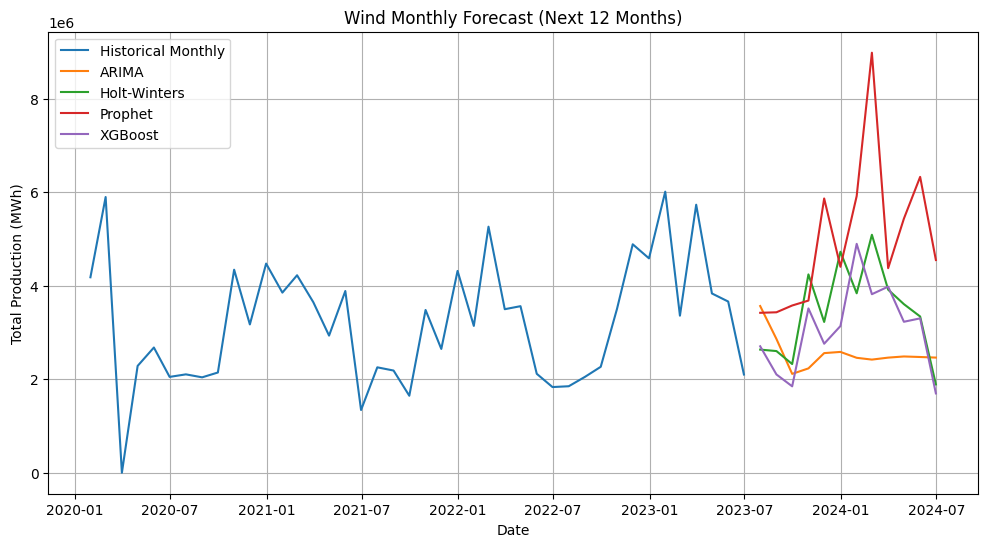

In [8]:
# MULTI-MODEL MONTHLY FORECASTING FOR SOLAR & WIND POWER

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 1. LOAD DATA
# Replace with your actual Kaggle dataset path
df = pd.read_csv("/kaggle/input/wind-solar-electricity-production/intermittent-renewables-production-france.csv")

df['Date'] = pd.to_datetime(df['Date'])

# Aggregate daily to monthly totals
df = df.groupby(['Date', 'Source'])['Production'].sum().unstack()
df.columns.name = None
monthly_df = df.resample('M').sum()

# 2. FORECAST HORIZON
forecast_months = 12  # predict next 12 months

# 3. MODEL FUNCTIONS (MONTHLY SERIES)

def forecast_arima(series):
    model = ARIMA(series, order=(2,1,2))
    fit = model.fit()
    return fit.forecast(steps=forecast_months)


def forecast_holt(series):
    model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12)
    fit = model.fit()
    return fit.forecast(forecast_months)


def forecast_prophet(series):
    dfp = series.reset_index().rename(columns={'Date':'ds', series.name: 'y'})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    # Add monthly seasonality manually
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=forecast_months, freq='M')
    pred = m.predict(future)
    return pred.set_index('ds')['yhat'].iloc[-forecast_months:]


def forecast_xgb(series):
    df_feat = pd.DataFrame({
        'y': series.values,
        'month': series.index.month,
        'year': series.index.year,
        'lag1': series.shift(1).values,
        'lag2': series.shift(2).values,
    }, index=series.index).dropna()

    X = df_feat.drop('y', axis=1)
    y = df_feat['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    # iterative forecasting
    last = df_feat['y'].values.tolist()
    preds = []
    for i in range(forecast_months):
        next_month = series.index[-1] + pd.DateOffset(months=i+1)
        feat = np.array([[next_month.month, next_month.year, last[-1], last[-2]]])
        p = model.predict(feat)[0]
        preds.append(p)
        last.append(p)

    future_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(), periods=forecast_months, freq='M')
    return pd.Series(preds, index=future_index)

# 4. PLOT COMPARISON

def plot_monthly_forecasts(series, name):
    arima_f = forecast_arima(series)
    holt_f = forecast_holt(series)
    prop_f = forecast_prophet(series)
    xgb_f = forecast_xgb(series)

    plt.figure(figsize=(12,6))
    plt.plot(series, label='Historical Monthly')
    plt.plot(arima_f, label='ARIMA')
    plt.plot(holt_f, label='Holt-Winters')
    plt.plot(prop_f, label='Prophet')
    plt.plot(xgb_f, label='XGBoost')
    plt.title(f'{name} Monthly Forecast (Next {forecast_months} Months)')
    plt.xlabel('Date')
    plt.ylabel('Total Production (MWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. RUN AND VISUALIZE
plot_monthly_forecasts(monthly_df['Solar_MWh'] if 'Solar_MWh' in monthly_df.columns else monthly_df['Solar'], 'Solar')
plot_monthly_forecasts(monthly_df['Wind_MWh'] if 'Wind_MWh' in monthly_df.columns else monthly_df['Wind'], 'Wind')


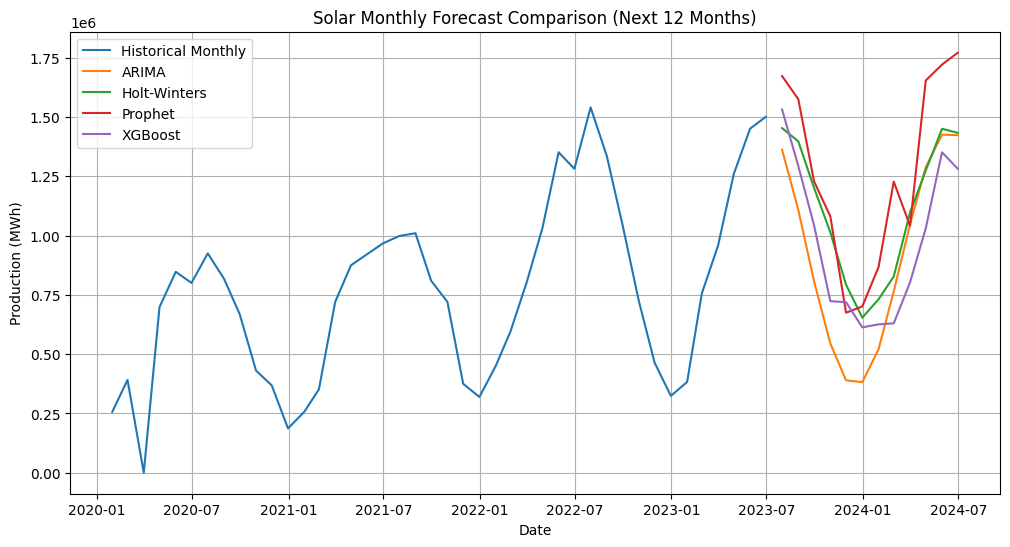

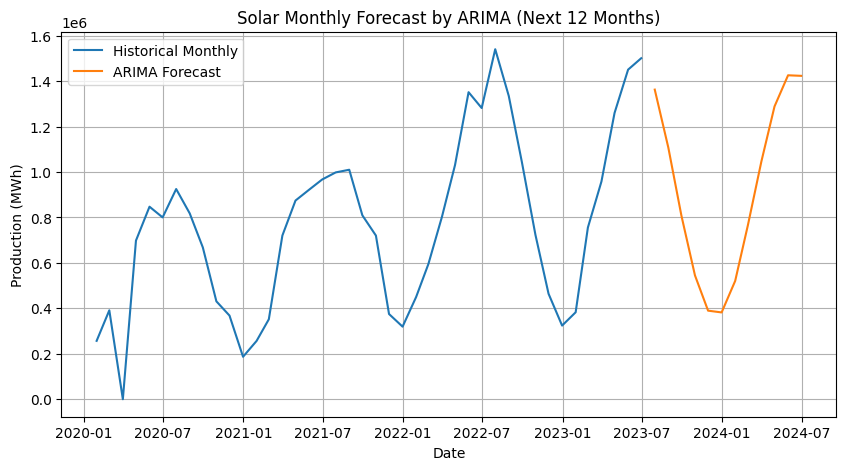

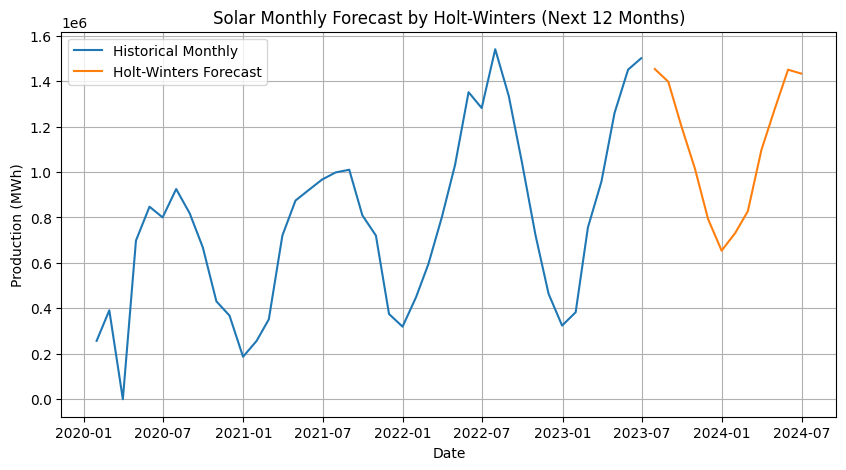

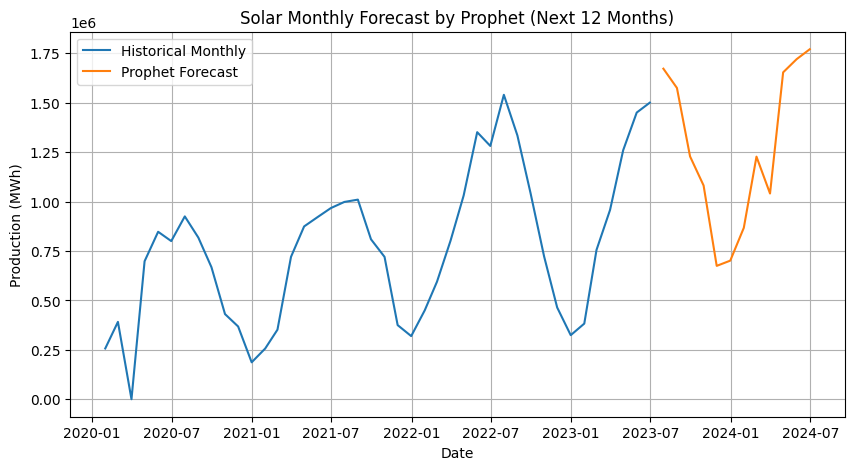

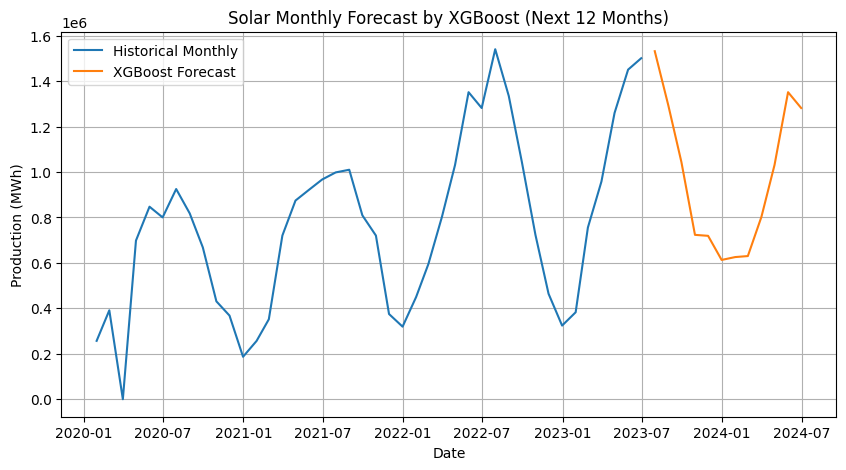

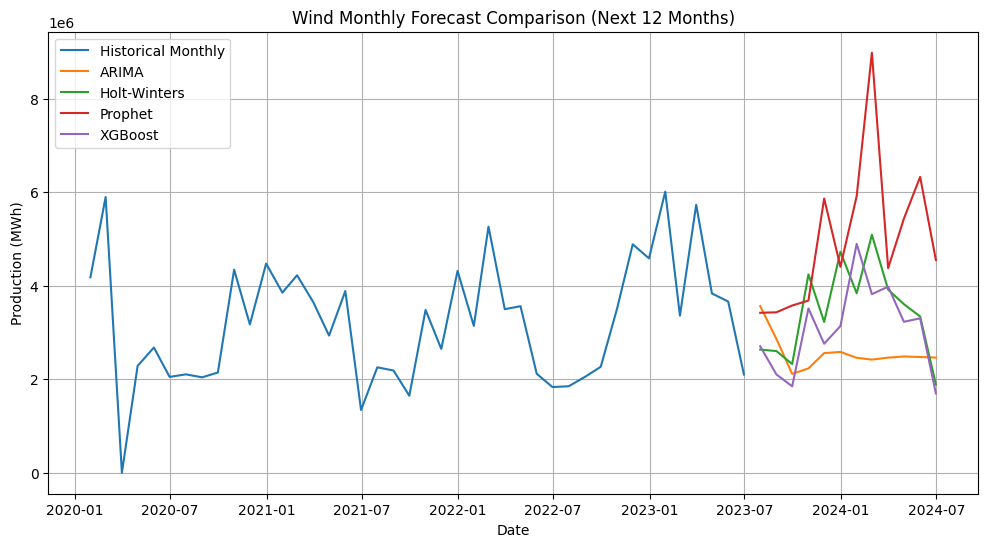

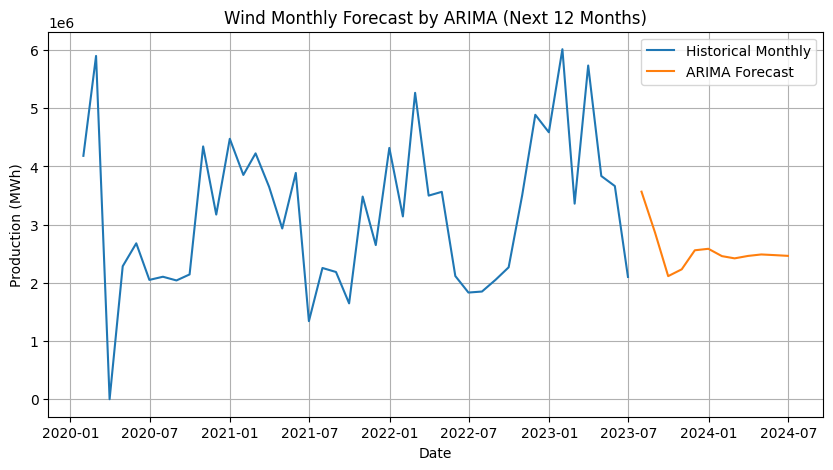

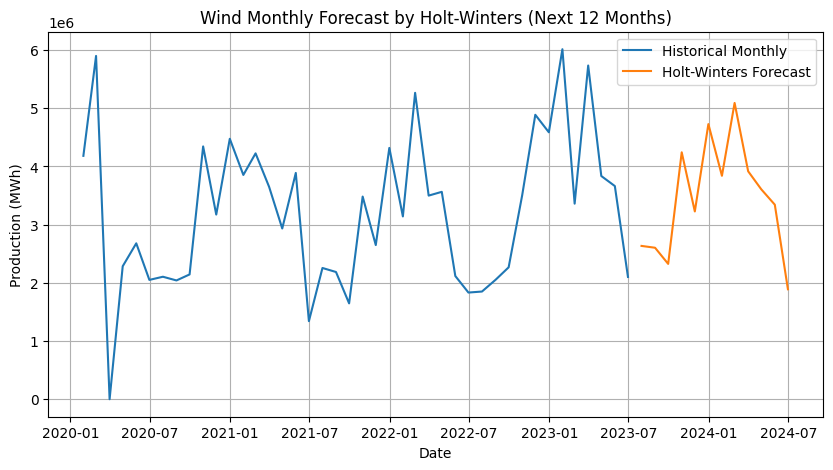

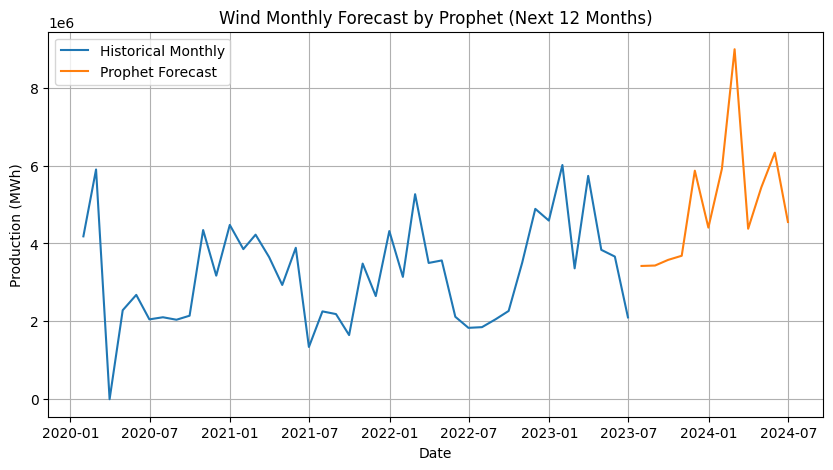

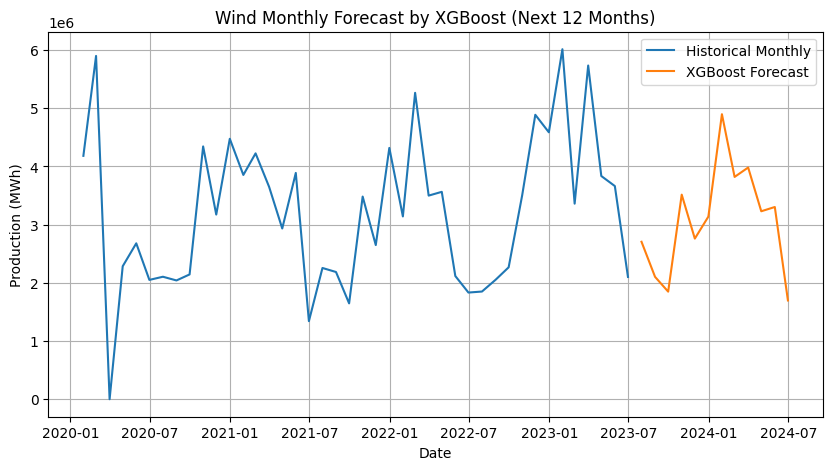

In [3]:
# MULTI-MODEL MONTHLY FORECASTING FOR SOLAR & WIND POWER

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import logging

# Suppress warnings and logs
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 1. LOAD DATA
# Replace with your actual Kaggle dataset path
df = pd.read_csv("/kaggle/input/wind-solar-electricity-production/intermittent-renewables-production-france.csv")

df['Date'] = pd.to_datetime(df['Date'])

# Aggregate daily to monthly totals
df = df.groupby(['Date', 'Source'])['Production'].sum().unstack()
df.columns.name = None
monthly_df = df.resample('M').sum()

# 2. FORECAST HORIZON
forecast_months = 12  # predict next 12 months

# 3. MODEL FUNCTIONS (MONTHLY SERIES)

def forecast_arima(series):
    model = ARIMA(series, order=(2,1,2))
    fit = model.fit()
    return fit.forecast(steps=forecast_months)


def forecast_holt(series):
    model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12)
    fit = model.fit()
    return fit.forecast(forecast_months)


def forecast_prophet(series):
    dfp = series.reset_index().rename(columns={'Date':'ds', series.name: 'y'})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=forecast_months, freq='M')
    pred = m.predict(future)
    return pred.set_index('ds')['yhat'].iloc[-forecast_months:]


def forecast_xgb(series):
    df_feat = pd.DataFrame({
        'y': series.values,
        'month': series.index.month,
        'year': series.index.year,
        'lag1': series.shift(1).values,
        'lag2': series.shift(2).values,
    }, index=series.index).dropna()

    X = df_feat.drop('y', axis=1)
    y = df_feat['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    last = df_feat['y'].values.tolist()
    preds = []
    for i in range(forecast_months):
        next_month = series.index[-1] + pd.DateOffset(months=i+1)
        feat = np.array([[next_month.month, next_month.year, last[-1], last[-2]]])
        p = model.predict(feat)[0]
        preds.append(p)
        last.append(p)

    future_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(), periods=forecast_months, freq='M')
    return pd.Series(preds, index=future_index)

# 4. PLOT FUNCTIONS

def plot_combined(series, name):
    arima_f = forecast_arima(series)
    holt_f = forecast_holt(series)
    prop_f = forecast_prophet(series)
    xgb_f = forecast_xgb(series)

    plt.figure(figsize=(12,6))
    plt.plot(series, label='Historical Monthly')
    plt.plot(arima_f, label='ARIMA')
    plt.plot(holt_f, label='Holt-Winters')
    plt.plot(prop_f, label='Prophet')
    plt.plot(xgb_f, label='XGBoost')
    plt.title(f'{name} Monthly Forecast Comparison (Next {forecast_months} Months)')
    plt.xlabel('Date')
    plt.ylabel('Production (MWh)')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_model(series, forecast, name, model_name):
    plt.figure(figsize=(10,5))
    plt.plot(series, label='Historical Monthly')
    plt.plot(forecast, label=f'{model_name} Forecast')
    plt.title(f'{name} Monthly Forecast by {model_name} (Next {forecast_months} Months)')
    plt.xlabel('Date')
    plt.ylabel('Production (MWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. RUN AND VISUALIZE

def run_forecasts(series, name):
    # Combined comparison plot
    plot_combined(series, name)
    # Individual model plots
    plot_model(series, forecast_arima(series), name, 'ARIMA')
    plot_model(series, forecast_holt(series), name, 'Holt-Winters')
    plot_model(series, forecast_prophet(series), name, 'Prophet')
    plot_model(series, forecast_xgb(series), name, 'XGBoost')

# 6. EXECUTE FOR SOLAR & WIND
for source in ['Solar', 'Wind']:
    col = f"{source}_MWh" if f"{source}_MWh" in monthly_df.columns else source
    run_forecasts(monthly_df[col], source)


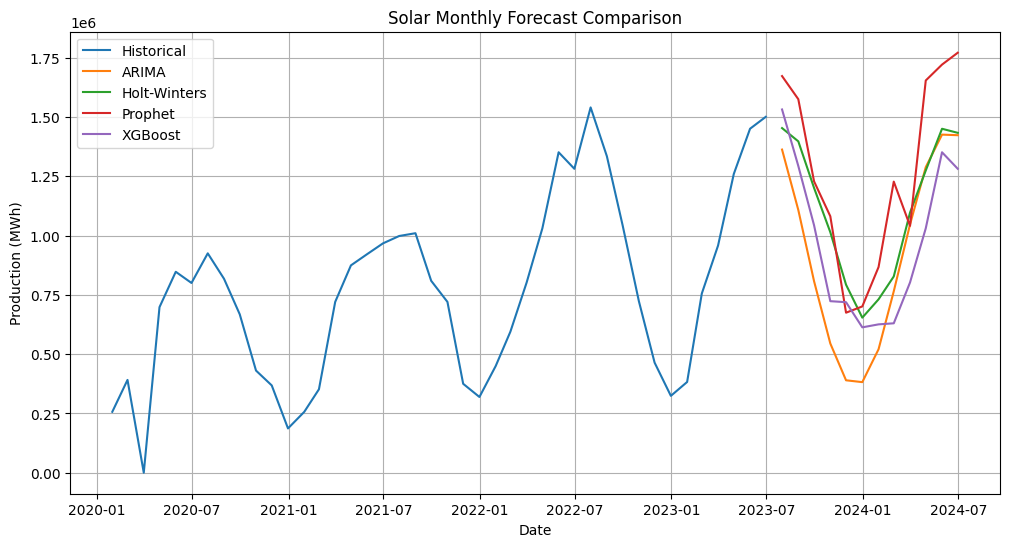

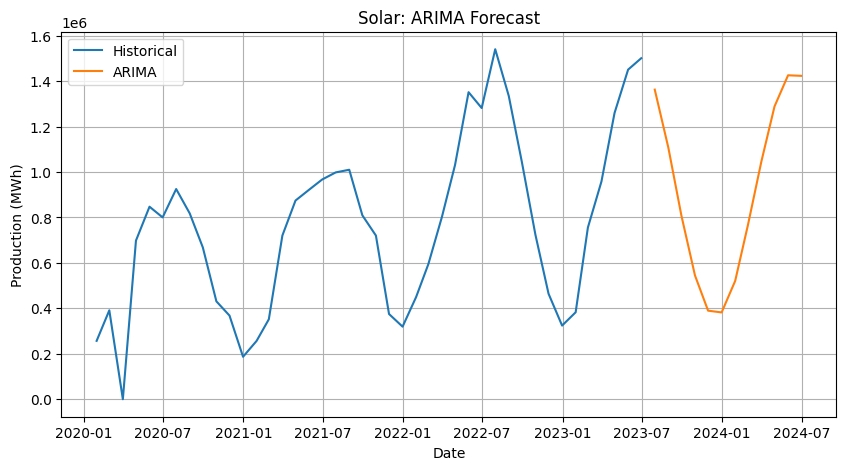

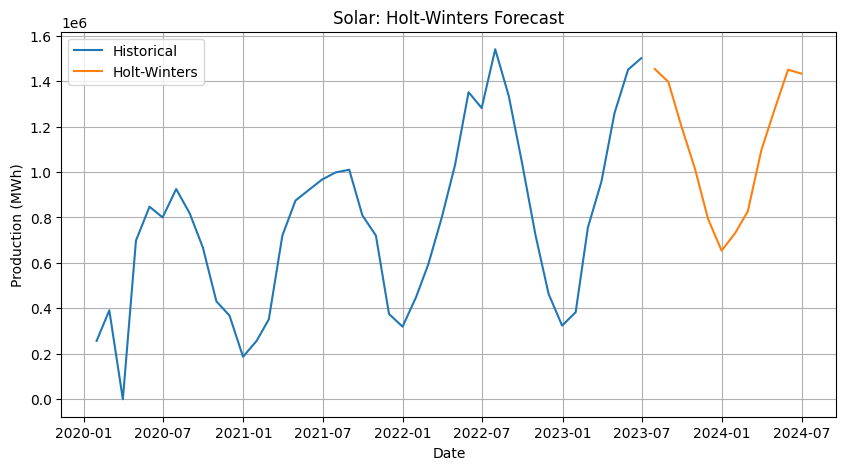

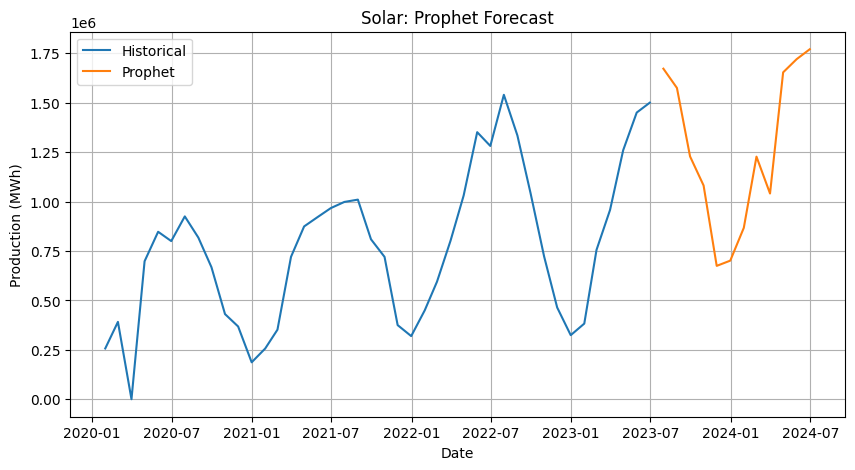

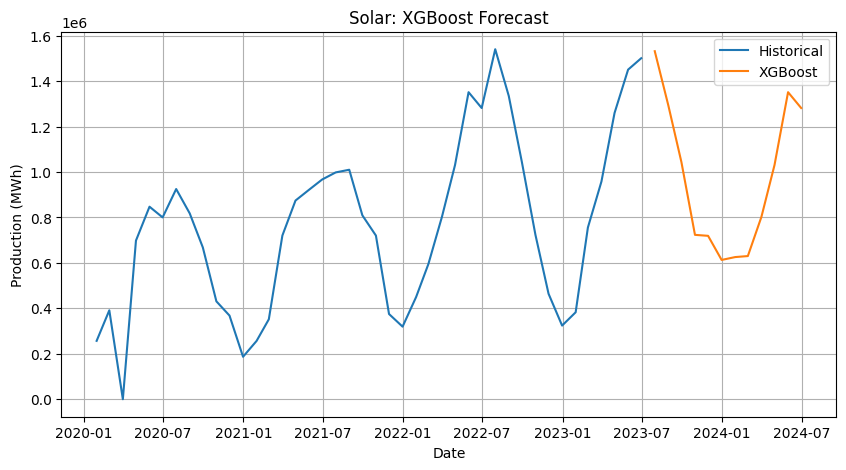

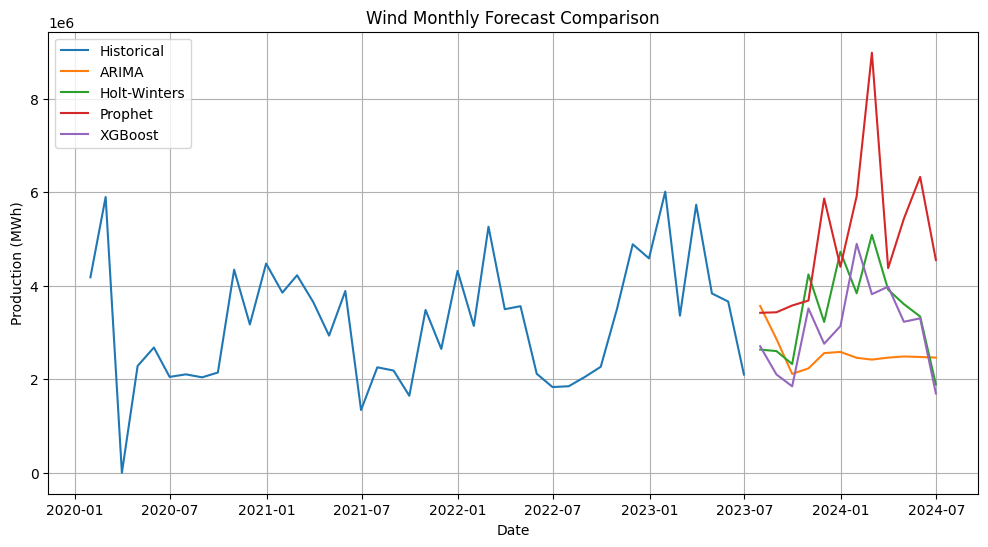

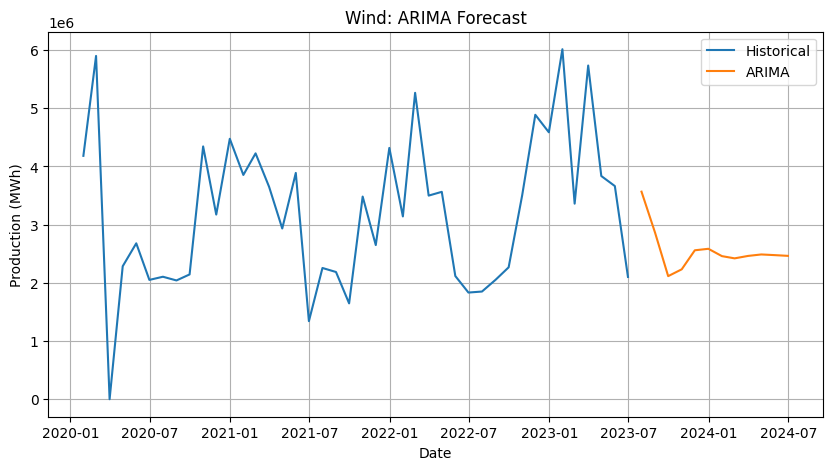

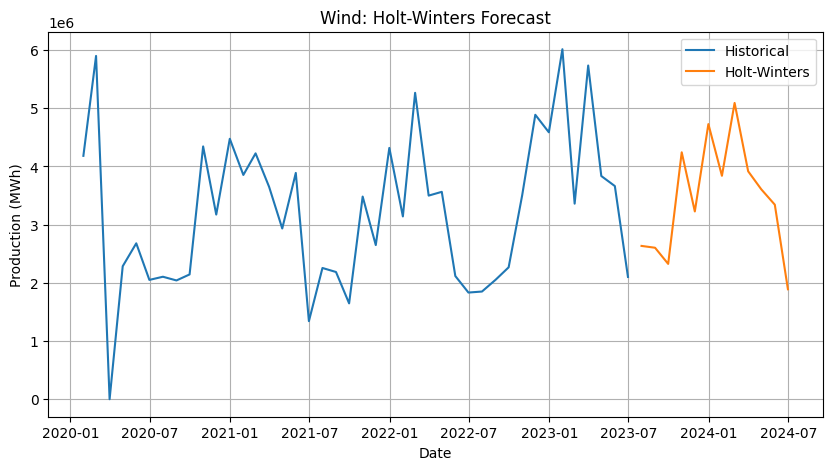

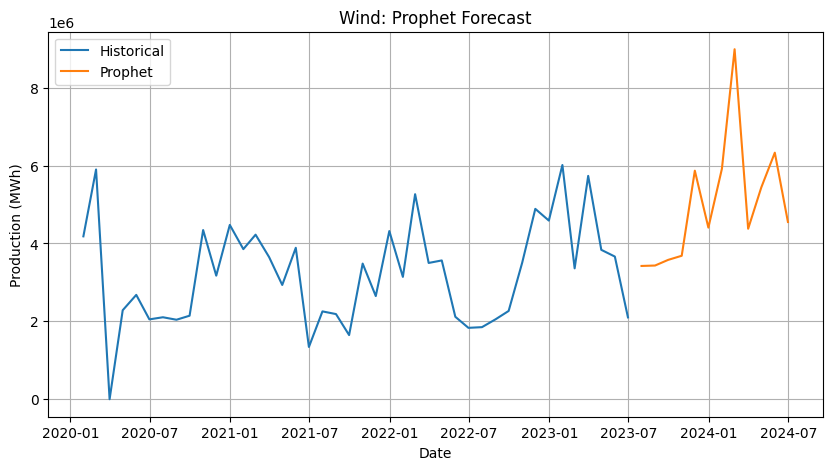

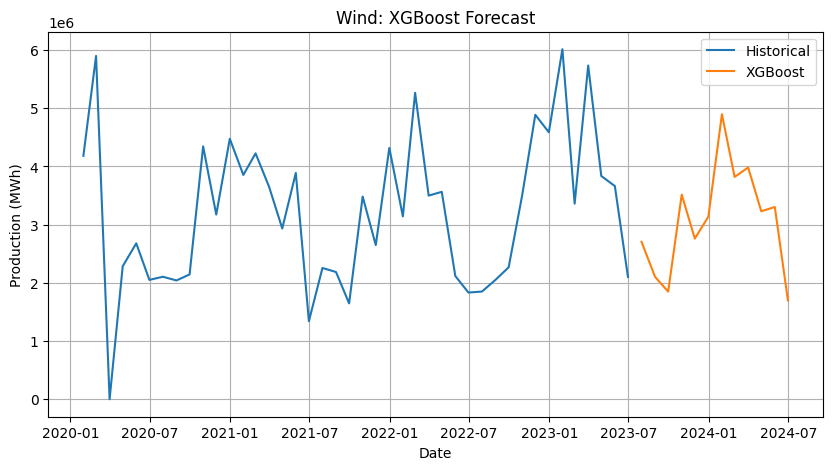

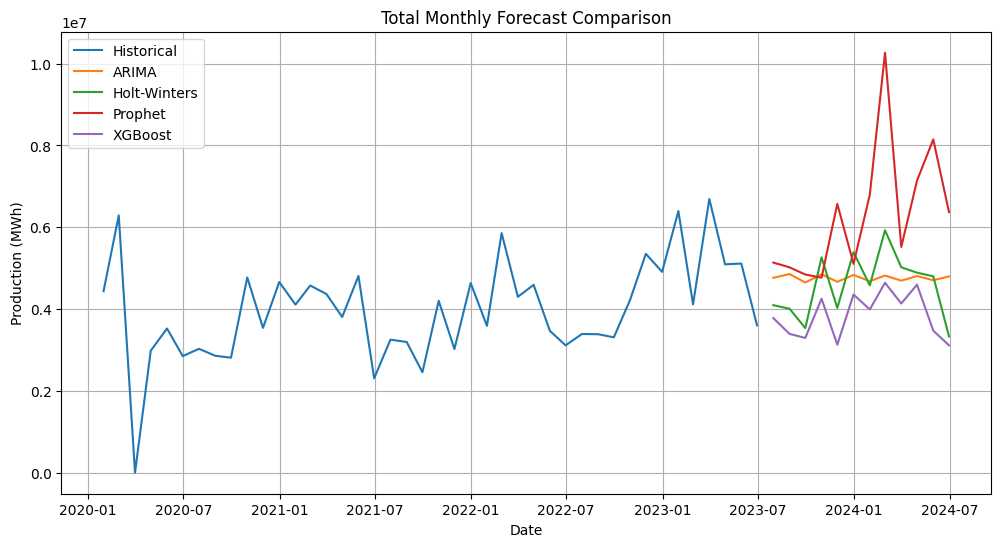

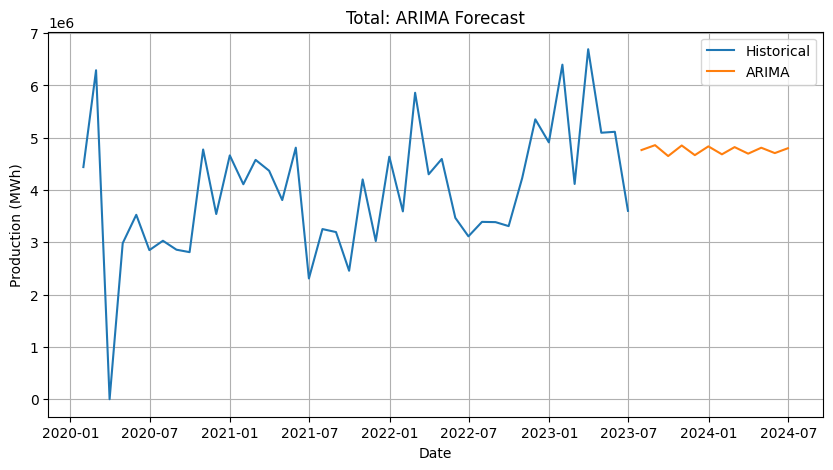

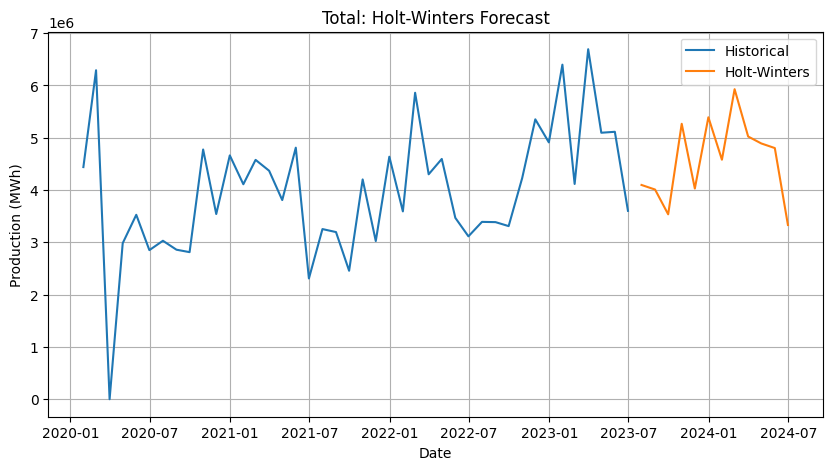

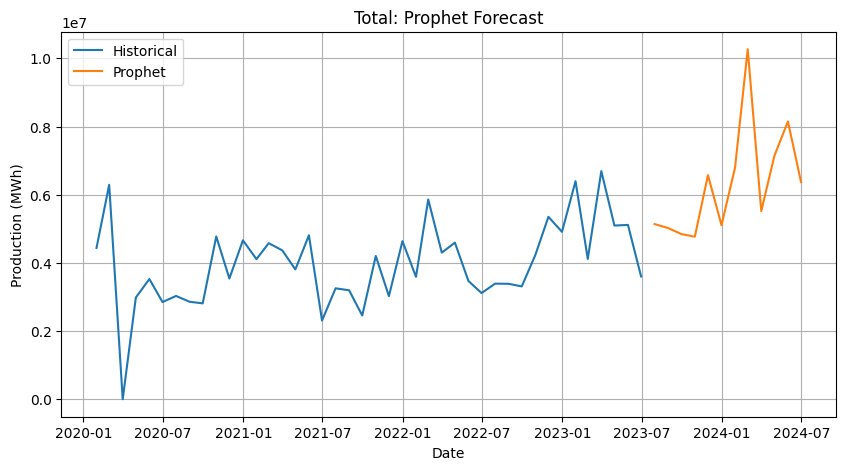

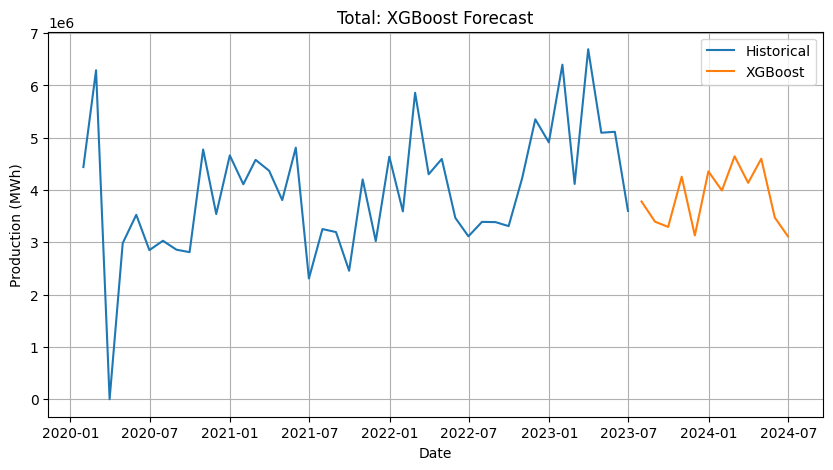

In [4]:
# MULTI-MODEL MONTHLY FORECASTING FOR SOLAR, WIND & TOTAL POWER

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import logging

# Suppress warnings and logs
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 1. LOAD DATA
# Replace with your actual Kaggle dataset path
df = pd.read_csv(
    "/kaggle/input/wind-solar-electricity-production/intermittent-renewables-production-france.csv"
)

df['Date'] = pd.to_datetime(df['Date'])

# 2. AGGREGATE TO MONTHLY TOTALS PER SOURCE
monthly = (
    df.groupby(['Date', 'Source'])['Production']
      .sum()
      .unstack()
      .resample('M')
      .sum()
)
monthly.columns.name = None
# Rename for clarity
monthly = monthly.rename(columns={'Solar': 'Solar_MWh', 'Wind': 'Wind_MWh'})

# 3. ADD TOTAL COLUMN
monthly['Total_MWh'] = monthly['Solar_MWh'] + monthly['Wind_MWh']

# 4. FORECAST HORIZON
forecast_months = 12  # predict next 12 months

# 5. MODEL FUNCTIONS

def forecast_arima(series):
    model = ARIMA(series, order=(2,1,2))
    fit = model.fit()
    return fit.forecast(steps=forecast_months)


def forecast_holt(series):
    model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12)
    fit = model.fit()
    return fit.forecast(forecast_months)


def forecast_prophet(series):
    dfp = series.reset_index().rename(columns={'Date':'ds', series.name: 'y'})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=forecast_months, freq='M')
    pred = m.predict(future)
    return pred.set_index('ds')['yhat'].iloc[-forecast_months:]


def forecast_xgb(series):
    df_feat = pd.DataFrame({
        'y': series.values,
        'month': series.index.month,
        'year': series.index.year,
        'lag1': series.shift(1).values,
        'lag2': series.shift(2).values,
    }, index=series.index).dropna()

    X = df_feat.drop('y', axis=1)
    y = df_feat['y']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    last = df_feat['y'].values.tolist()
    preds = []
    for i in range(forecast_months):
        next_month = series.index[-1] + pd.DateOffset(months=i+1)
        feat = np.array([[next_month.month, next_month.year, last[-1], last[-2]]])
        p = model.predict(feat)[0]
        preds.append(p)
        last.append(p)

    future_index = pd.date_range(
        start=series.index[-1] + pd.offsets.MonthEnd(),
        periods=forecast_months,
        freq='M'
    )
    return pd.Series(preds, index=future_index)

# 6. PLOTTING FUNCTIONS

def plot_combined(series, name):
    # Combined comparison of 4 models
    arima_f = forecast_arima(series)
    holt_f = forecast_holt(series)
    prop_f = forecast_prophet(series)
    xgb_f = forecast_xgb(series)

    plt.figure(figsize=(12,6))
    plt.plot(series, label='Historical')
    plt.plot(arima_f, label='ARIMA')
    plt.plot(holt_f, label='Holt-Winters')
    plt.plot(prop_f, label='Prophet')
    plt.plot(xgb_f, label='XGBoost')
    plt.title(f'{name} Monthly Forecast Comparison')
    plt.xlabel('Date')
    plt.ylabel('Production (MWh)')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_individual(series, name):
    # Individual model plots
    for model_name, func in [
        ('ARIMA', forecast_arima),
        ('Holt-Winters', forecast_holt),
        ('Prophet', forecast_prophet),
        ('XGBoost', forecast_xgb)
    ]:
        fc = func(series)
        plt.figure(figsize=(10,5))
        plt.plot(series, label='Historical')
        plt.plot(fc, label=model_name)
        plt.title(f'{name}: {model_name} Forecast')
        plt.xlabel('Date')
        plt.ylabel('Production (MWh)')
        plt.legend()
        plt.grid(True)
        plt.show()

# 7. EXECUTE FORECASTS FOR ALL SOURCES
for col in ['Solar_MWh', 'Wind_MWh', 'Total_MWh']:
    name = col.replace('_MWh', '')
    series = monthly[col]
    plot_combined(series, name)
    plot_individual(series, name)
